# PS1-2 Imcomplete, Positive-Only Labels

In [101]:
import numpy as np
import src.util as util
from src.linear_model import LinearModel
from matplotlib import pyplot as plt

In [102]:
# set paths
ds3_train_path='./data/ds3_train.csv'
ds3_val_path='./data/ds3_valid.csv'
ds3_test_path='./data/ds3_test.csv'
ps1_2c_pred_path = './output/p02c_pred.txt'
ps1_2d_pred_path = './output/p02d_pred.txt'
ps1_2e_pred_path = './output/p02e_pred.txt'

In [103]:
# load data
x_train, t_train = util.load_dataset(ds3_train_path, label_col='t')
_, y_train = util.load_dataset(ds3_train_path, label_col='y')

x_val, t_val = util.load_dataset(ds3_val_path, label_col='t')
_, y_val = util.load_dataset(ds3_val_path, label_col='y')

x_test, t_test = util.load_dataset(ds3_test_path, label_col='t')
_, y_test = util.load_dataset(ds3_test_path, label_col='y')

In [104]:
# define acc function
def acc(y_pred, label):
    """Calculate accuracy given predictions and labels.

    Args:
        y_pred: propabilities predicted by the model. Shape (n, 1).
        label: true labels. Shape (n,).

    """
    y_pred = y_pred.reshape(-1)
    res = ((y_pred >= 0.5) == (label))
    return res[res == True].shape[0] / label.shape[0]

### (a)

Apply chain rule of conditional probability:

\begin{equation}\notag
\begin{aligned}
    P(y^{(i)}=1,t^{(i)}=1,x^{(i)}) &= P(y^{(i)}=1|t^{(i)}=1,x^{(i)})P(t^{(i)}=1|x^{(i)})P(x^{(i)})\\
    &=P(t^{(i)}=1|y^{(i)}=1,x^{(i)})P(y^{(i)}=1|x^{(i)})P(x^{(i)}).
\end{aligned}
\end{equation}

According to the assumption $P(y^{(i)}=1|t^{(i)}=1,x^{(i)}) = P(y^{(i)}=1|t^{(i)}=1)$ 
and the fact that $P(t^{(i)}=1|y^{(i)}=1,x^{(i)}) = 1$, we can solve for $P(t^{(i)}=1|x^{(i)})$:

\begin{equation}\notag
P(t^{(i)}=1|x^{(i)}) =\frac{P(y^{(i)}=1|x^{(i)})}{P(y^{(i)}=1|t^{(i)}=1)}.
\end{equation}

Thus the constant factor $\alpha = P(y^{(i)}=1|t^{(i)}=1)$, which means the fraction of positive samples that are labeled in all positive samples.

### (b)

For all $x^{(i)}\in V_+$, $h(x^{(i)})\approx p(y^{(i)}=1|x^{(i)})=\alpha P(t^{(i)}=1|x^{(i)})=\alpha$.

### (c) Apply logistic regression on true labels. 

In [105]:
# copy logistic regression implemented in PS1-1
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        def h(theta, x):
            """
            Compute hypothesis function $h\\_\\theta(x) = sigmoid(x\\theta)$.
            
            Args:
                theta: model parameters. Shape (n,).
                x: Training example inputs. Shape (m, n).

            Returns:
                $h\\_\\theta(x)$ of shape (m,)
            """
            return 1 / (1 + np.exp(-np.matmul(x, theta.reshape(-1, 1))))
        

        def gradient(theta, x, y):
            """
            Compute gradient of $J(\\theta)$, i.e., $\\nabla\\_\\thetaJ(\\theta)$.

            Args:
                theta: model parameters. Shape (n,).
                x: Training example inputs. Shape (m, n).
                y: Training example labels. Shape (m,).

            Returns:
                Output of shape (n, )
            """
            res = x * (y.reshape(-1, 1) - h(theta, x))
            return -res.mean(axis=0)
        
        def hessian(theta, x):
            """
            Compute Hessian matrix of $J(\\theta)$.

            Args:
                theta: model parameters. Shape (n,).
                x: Training example inputs. Shape (m, n).
                y: Training example labels. Shape (m,).

            Returns:
                Output of shape (n, n)
            """
            x1 = x[:, :, np.newaxis]    # shape (m, n, 1)
            x2 = x[:, np.newaxis, :]    # shape (m, 1, n)
            res = np.matmul(x1, x2) # shape (m, n, n)
            prob = h(theta, x)  # shape (m,)
            prob = prob.reshape(-1, 1, 1)   # shape (m, 1, 1)
            res = res * prob * (1 - prob)
            return res.mean(axis=0)
        
        # run Newton's Method to find theta where grad = 0
        # thus minimize J(\theta)
        if self.theta is None:
            self.theta = np.zeros(x.shape[1])
        grad = gradient(self.theta, x, y)
        while(np.max(np.abs(grad)) >= self.eps):
            # print('Current gradient of J(theta) is', grad)
            # print('Current J(theta) is', -(y * np.log(h(self.theta, x)).squeeze(1) + \
            #                             (1 - y) * np.log(1 - h(self.theta, x)).squeeze(1)).mean())
            H = hessian(self.theta, x)
            H_inv = np.linalg.inv(H)
            self.theta = self.theta - np.matmul(H_inv, grad)
            grad = gradient(self.theta, x, y)
        # print('gradient of J(\\theta) is', grad)
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return 1 / (1 + np.exp(-np.matmul(x, self.theta.reshape(-1, 1))))
        # *** END CODE HERE ***

In [106]:
lr_clf = LogisticRegression()
lr_x_train = util.add_intercept(x_train)
lr_clf.fit(lr_x_train, t_train)

In [107]:
# plot the decision boundary on training set
# util.plot(lr_x_train, t_train, lr_clf.theta)

In [108]:
# test the model
lr_x_test = util.add_intercept(x_test)
t_test_pred = lr_clf.predict(lr_x_test)
np.savetxt(ps1_2c_pred_path, t_test_pred)

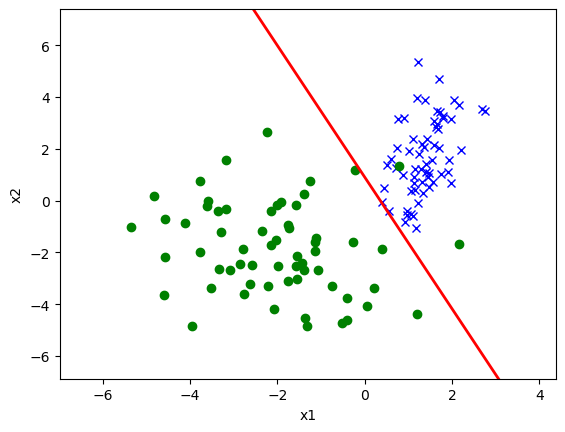

In [109]:
# plot the decision boundary on test set
util.plot(lr_x_test, t_test, lr_clf.theta)

In [110]:
# print accuracy on training and test sets
print('Accuracy on training set:', acc(lr_clf.predict(lr_x_train), t_train))
print('Accuracy on test set:', acc(lr_clf.predict(lr_x_test), t_test))

Accuracy on training set: 0.9632
Accuracy on test set: 0.9838709677419355


Here the classifier models $P(t^{(i)}=1|x^{(i)})$.

### (d) Train on y-labels and test on true labels

In [111]:
lr_clf = LogisticRegression()
lr_clf.fit(lr_x_train, y_train)

In [112]:
# plot the decision boundary on training set
# util.plot(lr_x_train, y_train, lr_clf.theta)

In [113]:
# test the model
lr_x_test = util.add_intercept(x_test)
t_test_pred = lr_clf.predict(lr_x_test)
np.savetxt(ps1_2d_pred_path, t_test_pred)

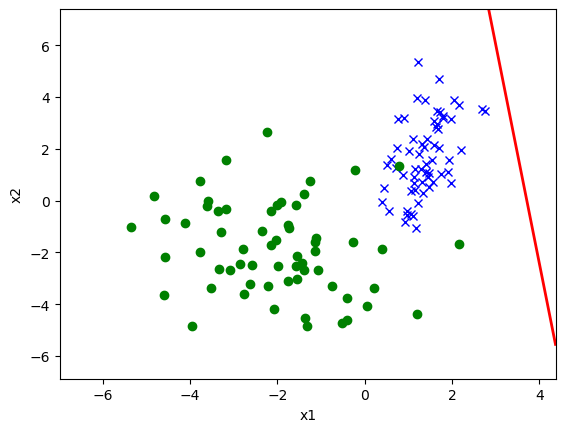

In [114]:
# plot the decision boundary on test set
util.plot(lr_x_test, t_test, lr_clf.theta)

In [115]:
# print accuracy on training and test sets
print('Accuracy on training set (with y-labels):', acc(lr_clf.predict(lr_x_train), y_train))
print('Accuracy on training set (with true-labels):', acc(lr_clf.predict(lr_x_train), t_train))
print('Accuracy on test set:', acc(lr_clf.predict(lr_x_test), t_test))

Accuracy on training set (with y-labels): 0.9
Accuracy on training set (with true-labels): 0.5
Accuracy on test set: 0.5


Here the classifier models $P(y^{(i)}=1|x^{(i)})$. We have proved that $P(y^{(i)}=1|x^{(i)}) = \alpha$ for all $x^{(i)}\in V_+$, so the classifier will predict $\alpha$ for all $x^{(i)}\in V_+$. We can use the validation set to compute $\alpha$ and thus correct probabilities given out by models trained on training set.

### (e)  Apply correction factor using validation set and test on true labels

In [116]:
lr_clf = LogisticRegression()
lr_clf.fit(lr_x_train, y_train)
# Now the classifier still models $P(y^{(i)}=1|x^{(i)})$

In [117]:
# compute correction term \alpha
x_val_input = x_val[y_val == 1] # $V_+$
lr_x_val_input = util.add_intercept(x_val_input)
alpha = np.mean(lr_clf.predict(lr_x_val_input), axis=0)

In [118]:
alpha

array([0.1717465])

In [119]:
t_test_pred = lr_clf.predict(lr_x_test) / alpha
# After correction the model gives out $P(t^{(i)}=1|x^{(i)})$

In [120]:
# compute accuracy on test set
print('Accuracy on test set:', acc(t_test_pred, t_test))

Accuracy on test set: 0.9516129032258065


Finally, we plot the decision boundary after correction on test set. To achieve this, we find the new $\theta$ after correction by solving the equation defined by the decision boundary 

$$\frac{1}{\alpha} \frac{1}{1 + \exp(- \theta^T x)} = \frac{1}{2}.$$

By simplifying the equation, we get 

$$\theta^Tx+\ln\left(\frac{2}{\alpha}-1\right)=0.$$

Since we add intercept to $x$'s first column, thus we can directly add $\ln\left(\frac{2}{\alpha}-1\right)$ to $\theta _0$.

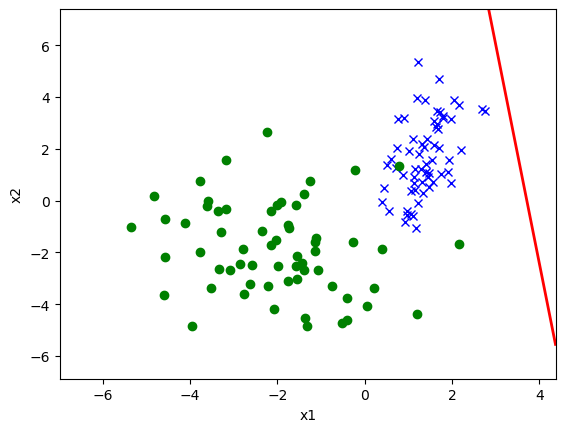

In [121]:
# plot the decision boundary before correction on test set
util.plot(lr_x_test, t_test, lr_clf.theta)

/tmp/ipykernel_4072444/3545588039.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corrected_theta[0] += np.log(2 / alpha - 1)


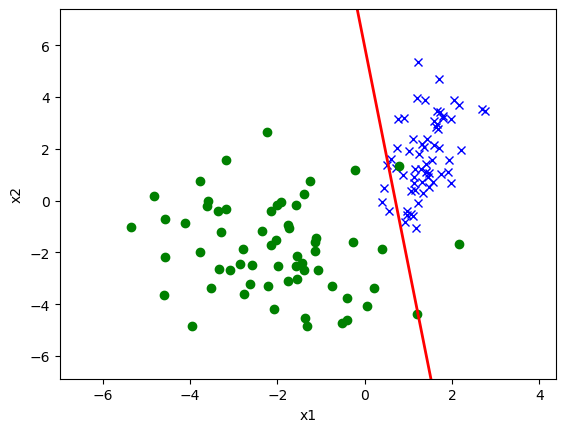

In [126]:
# plot the decision boundary after correction on test set
corrected_theta = lr_clf.theta.copy()
corrected_theta[0] += np.log(2 / alpha - 1)
util.plot(lr_x_test, t_test, corrected_theta)

Therefore, the correction we made is just translating the decidion boundary.